#**1) EXPLORATIVE DATA ANALYSIS**

---


In [6]:
%%capture
!pip install -U spaCy
!python -m spacy download it_core_news_lg

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import string
import re
import requests
import random

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns
import matplotlib.colors as mcolors

# Pre-processing
import spacy
from spacy.lang.it import Italian
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# Gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from multiprocessing import cpu_count
import gensim.downloader as api
# Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Models and utils
from sklearn.preprocessing import MinMaxScaler
# Tensorflow-keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
BASE_PATHS = [
    # Base paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/',

    # Base paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/'
]

IMAGES_PATHS = [
    # Images paths for training
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_1/images_task1_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_2/images_task2_train/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/dankmemes_task_3/images_task3_train/',

    # Images paths for testing
    'https://cdn.albertovalerio.com/datasets/dankmemes/1_test/1_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/2_test/2_test/',
    'https://cdn.albertovalerio.com/datasets/dankmemes/3_test/3_test/'
]

FILENAMES = [
    # Files for training
    'dankmemes_task1_train.csv',
    'dankmemes_task2_train.csv',
    'dankmemes_task3_train.csv',
    'dankmemes_task1_train_embeddings.csv',
    'dankmemes_task2_train_embeddings.csv',
    'dankmemes_task3_train_embeddings.csv',

    # Files for testing
    'meme_test_final.csv',
    'hate_test_final.csv',
    'event_test_final.csv',
    '1_test_embeddings.csv',
    '2_test_embeddings.csv',
    '3_test_embeddings_fixed.csv',

    # Utils
    'italian-swear-words-list_comma-separated-text-file.txt'
]

In [9]:
task_1_train = pd.read_csv(BASE_PATHS[0] + FILENAMES[0])
task_2_train = pd.read_csv(BASE_PATHS[1] + FILENAMES[1])
task_3_train = pd.read_csv(BASE_PATHS[2] + FILENAMES[2])

task_1_test = pd.read_csv(BASE_PATHS[3] + FILENAMES[6])
task_2_test = pd.read_csv(BASE_PATHS[4] + FILENAMES[7])
task_3_test = pd.read_csv(BASE_PATHS[5] + FILENAMES[8])

In [10]:
task_1_train.head()

,File,Engagement,Date,Manipulation,Visual,Text,Meme
0,0.jpg,11,2019-08-12,1,Salvini,satira cruda votaci.. saremo di parola il part...,1
1,1.jpg,2261,2019-08-21,0,0,"peccato per le accise, dai. c'eravamo quasi.",0
2,2.jpg,1327,2019-08-23,0,"Salvini, Di Maio","""che c'è ancora?"" ""aspetto un bambino""",1
3,3.jpg,18,2019-08-27,0,0,ora in onda speciale gr1 ascolta la diretta se...,0
4,4.jpg,617,2019-08-25,0,"Salvini, Di Maio",sta sciocchezza che sto pe fa e solo colpa tua,1


In [11]:
task_2_train.head()

,File,Engagement,Manipulation,Visual,Text,Hate Speech
0,1000.jpg,381,0,0,quando ti chiedono se sia peggiore fratelli d'...,1
1,1001.jpg,142,1,0,conte entra in un negozio di telefonia e passa...,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",i politicanti italici non vedono l'ora di anda...,1
3,1003.jpg,165,1,"Salvini, Renzi",sono scemo. io di più. scemo & più scemo,1
4,1004.jpg,44,0,0,"beppe grillo (2017) genova, 21 luglio 1948 pol...",0


In [12]:
task_3_train.head()

,File,Engagement,Date,Macro,Manipulation,Visual,Text,Event
0,2000.jpg,994,2019-05-09,0,1,Lega,suca salvini rosica,0
1,2001.jpg,20,2019-08-29,0,0,0,"in nome del popolo italiano, i cittadini itali...",0
2,2002.jpg,15,2016-07-08,0,0,0,"vladimir, ti interessa l'affare immigrati? asc...",0
3,2003.jpg,9,2019-08-29,0,0,"Meloni, Mattarella","""ma come chi sono? presidè sò io senza fotosci...",2
4,2004.jpg,12,2019-01-31,0,0,0,"cos'era? un topo di fogna? ah...no, salvini.",0


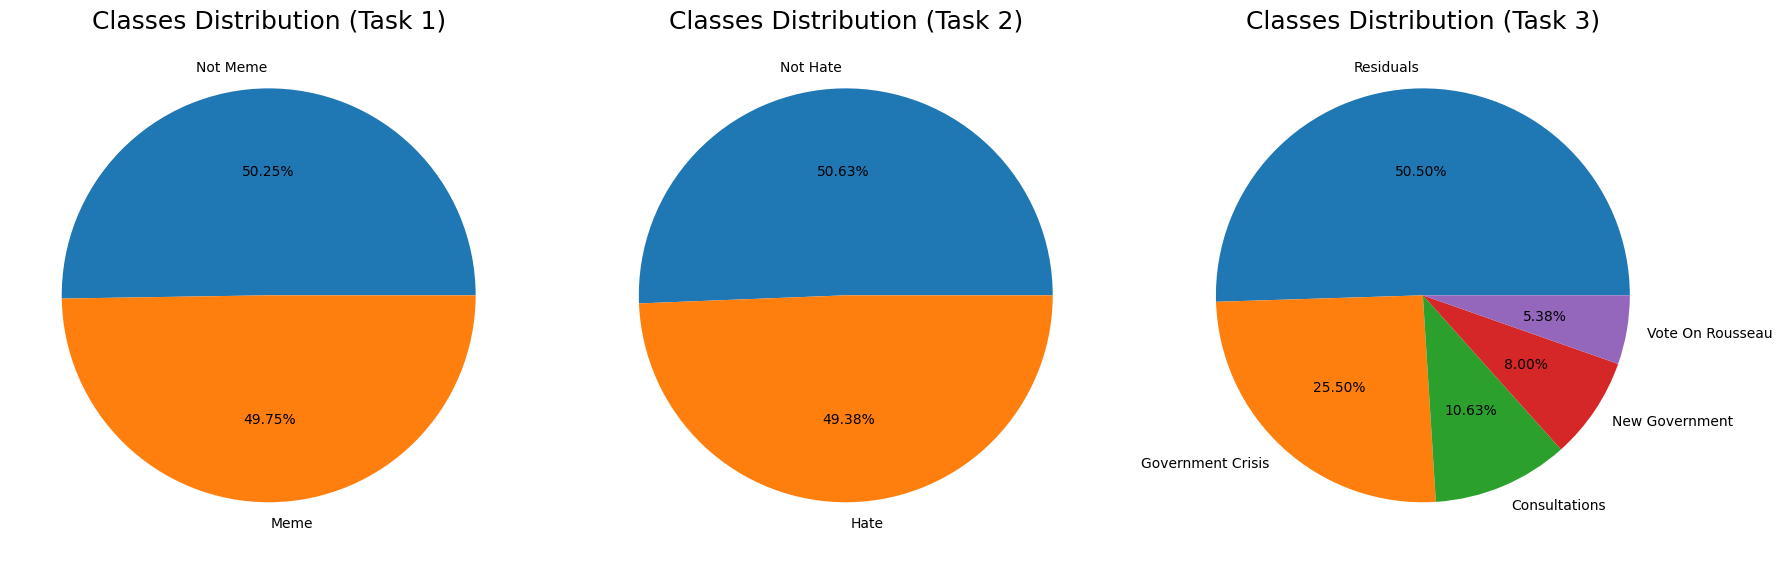

In [13]:
count1 = task_1_train['Meme'].value_counts()
count2 = task_2_train['Hate Speech'].value_counts()
count3 = task_3_train['Event'].value_counts()

labels1 = ['Not Meme', 'Meme']
labels2 = ['Not Hate', 'Hate']
labels3 = ['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau']

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
ax1.pie(count1, labels=labels1, autopct = '%1.2f%%')
ax2.pie(count2, labels=labels2, autopct = '%1.2f%%')
ax3.pie(count3, labels=labels3, autopct = '%1.2f%%')
ax1.set_title('Classes Distribution (Task 1)', fontsize = 18)
ax2.set_title('Classes Distribution (Task 2)', fontsize = 18)
ax3.set_title('Classes Distribution (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

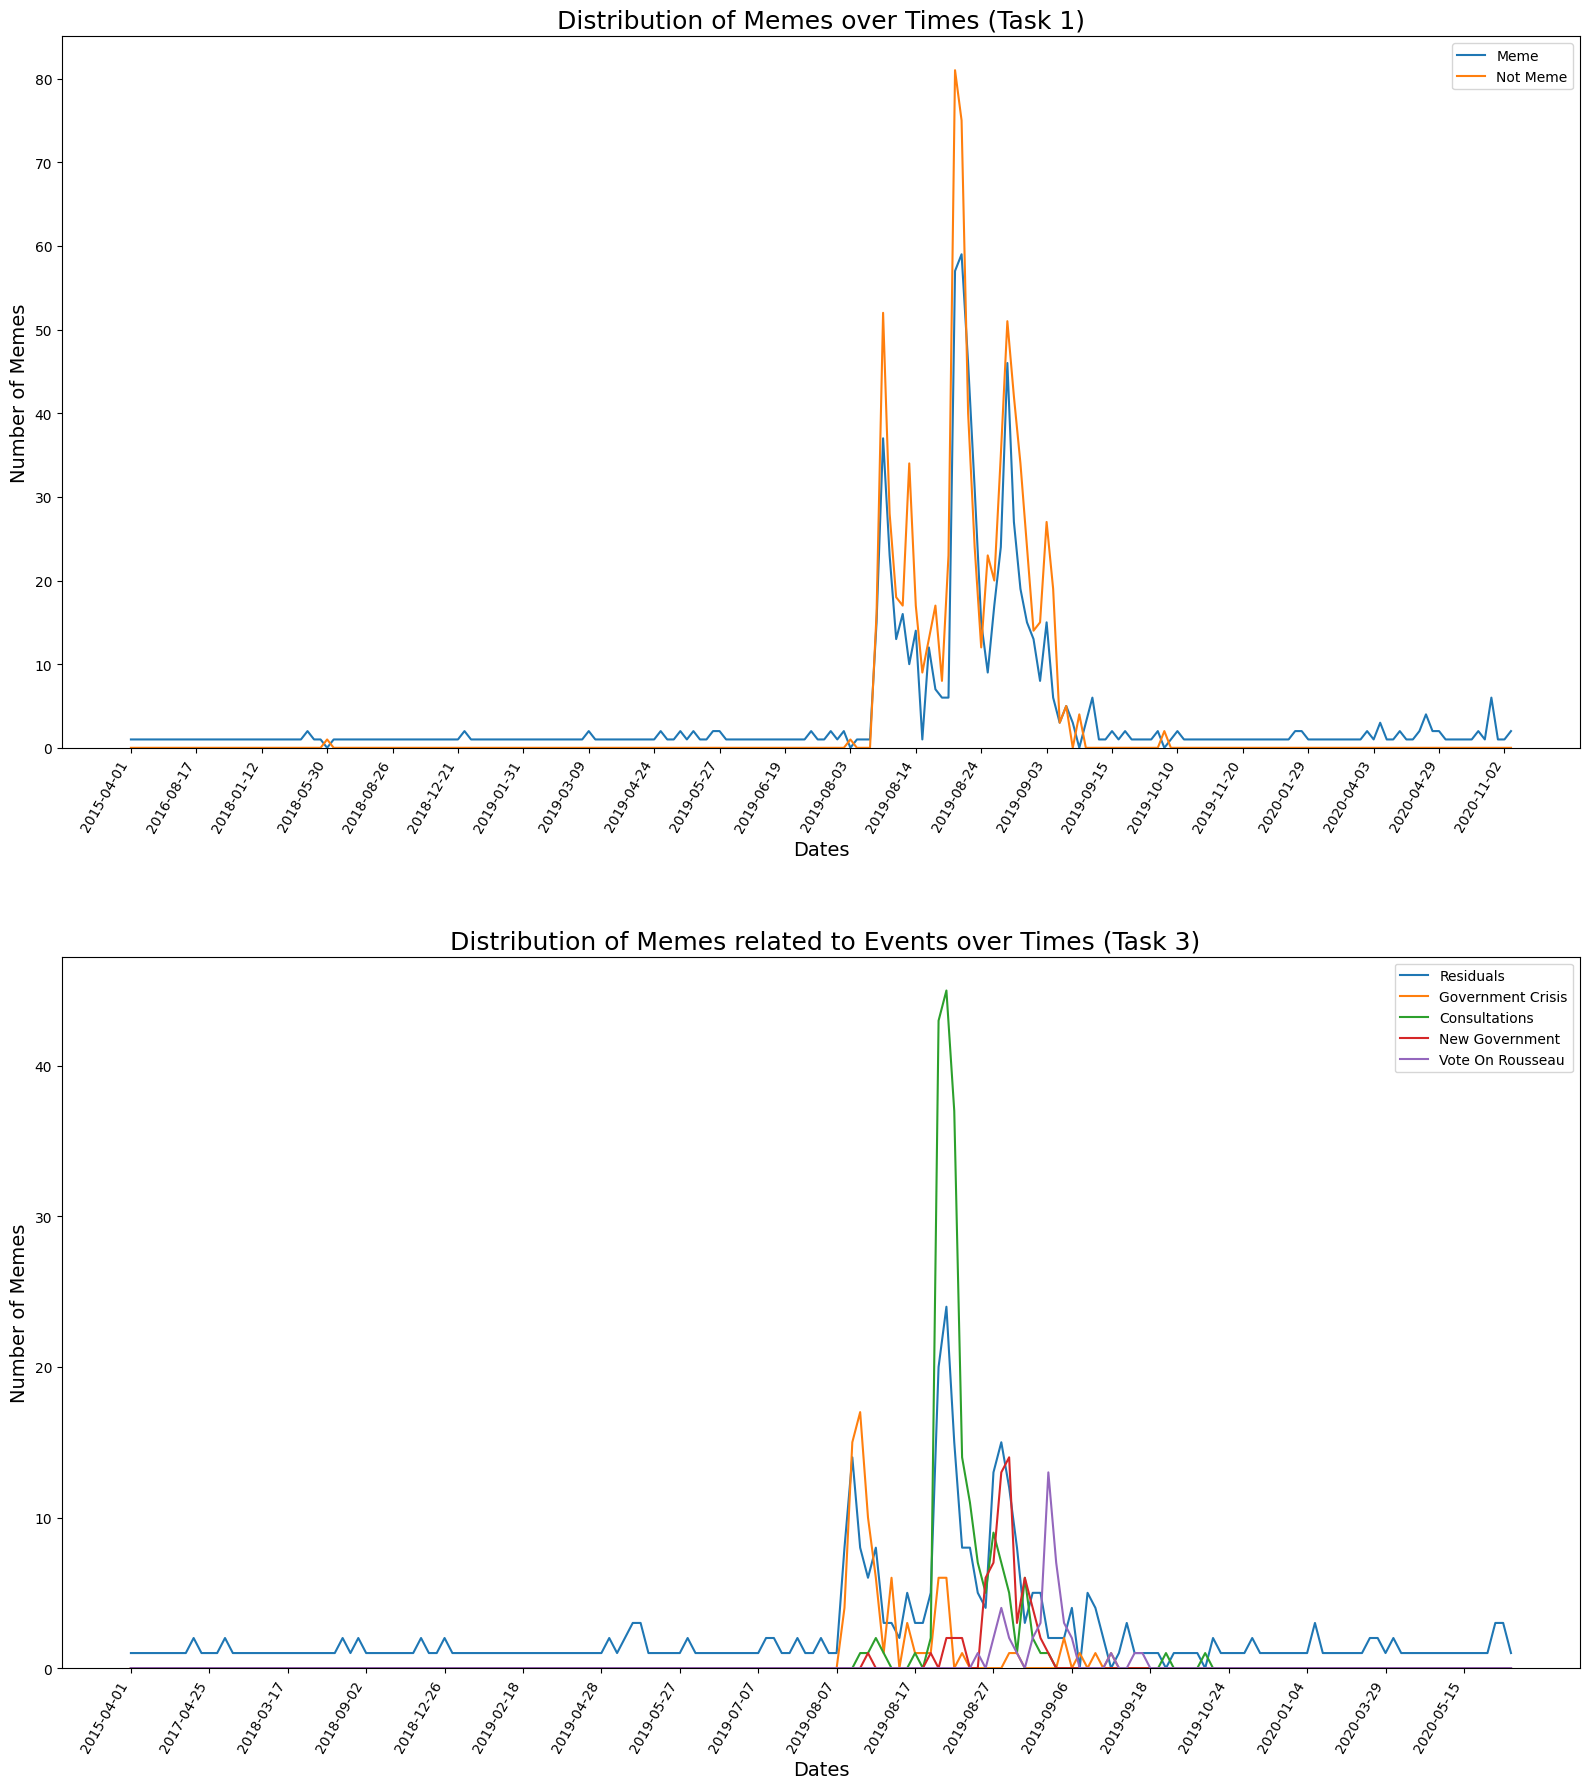

In [14]:
not_memes_by_date = task_1_train[task_1_train['Meme'] == 0].groupby('Date').size()
memes_by_date = task_1_train[task_1_train['Meme'] == 1].groupby('Date').size()
df1 = pd.DataFrame(index=pd.concat([not_memes_by_date, memes_by_date], axis=1).index, columns=['Meme','Not Meme'])
df1.loc[not_memes_by_date.index, 'Not Meme'] = not_memes_by_date.values
df1.loc[memes_by_date.index, 'Meme'] = memes_by_date.values
df1 = df1.sort_index()
df1 = df1.fillna(0)

class_0_by_date = task_3_train[task_3_train['Event'] == 0].groupby('Date').size()
class_1_by_date = task_3_train[task_3_train['Event'] == 1].groupby('Date').size()
class_2_by_date = task_3_train[task_3_train['Event'] == 2].groupby('Date').size()
class_3_by_date = task_3_train[task_3_train['Event'] == 3].groupby('Date').size()
class_4_by_date = task_3_train[task_3_train['Event'] == 4].groupby('Date').size()
df2 = pd.DataFrame(index=pd.concat([class_0_by_date, class_1_by_date, class_2_by_date, class_3_by_date, class_4_by_date], axis=1).index,
                   columns=['Residuals', 'Government Crisis', 'Consultations', 'New Government', 'Vote On Rousseau'])
df2.loc[class_0_by_date.index, 'Residuals'] = class_0_by_date.values
df2.loc[class_1_by_date.index, 'Government Crisis'] = class_1_by_date.values
df2.loc[class_2_by_date.index, 'Consultations'] = class_2_by_date.values
df2.loc[class_3_by_date.index, 'New Government'] = class_3_by_date.values
df2.loc[class_4_by_date.index, 'Vote On Rousseau'] = class_4_by_date.values
df2 = df2.sort_index()
df2 = df2.fillna(0)


fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(16, 18))
ax1.plot(df1.index, df1['Meme'], label='Meme')
ax1.plot(df1.index, df1['Not Meme'], label='Not Meme')
ax1.set_xlabel('Dates', fontsize = 14)
ax1.set_ylabel('Number of Memes', fontsize = 14)
ax1.set_xticks([df1.index[i] for i in range(0,len(df1.index),10)])
ax1.set_xticklabels([df1.index[i] for i in range(0,len(df1.index),10)], rotation = 60, ha="right")
ax1.set_ylim(ymin=0)
ax1.legend(loc='upper right')
ax1.set_title('Distribution of Memes over Times (Task 1)', fontsize = 18)
ax2.plot(df2.index, df2['Residuals'], label='Residuals')
ax2.plot(df2.index, df2['Government Crisis'], label='Government Crisis')
ax2.plot(df2.index, df2['Consultations'], label='Consultations')
ax2.plot(df2.index, df2['New Government'], label='New Government')
ax2.plot(df2.index, df2['Vote On Rousseau'], label='Vote On Rousseau')
ax2.set_xlabel('Dates', fontsize = 14)
ax2.set_ylabel('Number of Memes', fontsize = 14)
ax2.set_xticks([df2.index[i] for i in range(0,len(df2.index),10)])
ax2.set_xticklabels([df2.index[i] for i in range(0,len(df2.index),10)], rotation = 60, ha="right")
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper right')
ax2.set_title('\n\n Distribution of Memes related to Events over Times (Task 3)', fontsize = 18)

plt.tight_layout()
plt.show()

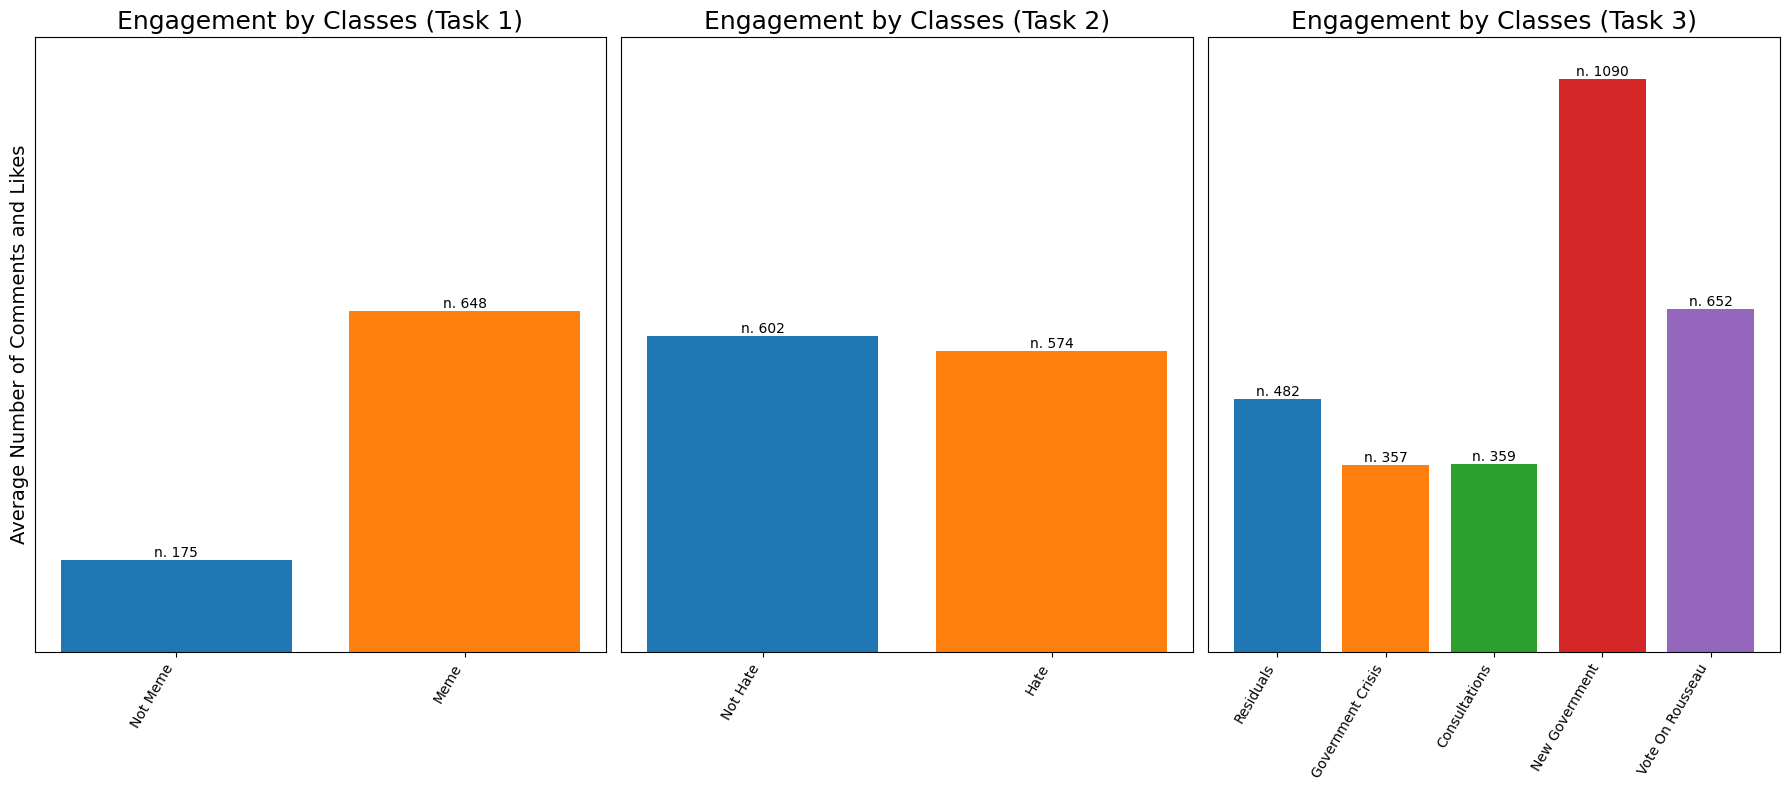

In [15]:
height1 = [
    task_1_train[task_1_train['Meme'] == 0]['Engagement'].mean(),
    task_1_train[task_1_train['Meme'] == 1]['Engagement'].mean()
]
height2 = [
    task_2_train[task_2_train['Hate Speech'] == 0]['Engagement'].mean(),
    task_2_train[task_2_train['Hate Speech'] == 1]['Engagement'].mean()
]
height3 = [
    task_3_train[task_3_train['Event'] == 0]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 1]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 2]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 3]['Engagement'].mean(),
    task_3_train[task_3_train['Event'] == 4]['Engagement'].mean(),
]

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 8))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.bar(labels1, height=height1, color=colors)
ax1.set_ylabel('Average Number of Comments and Likes', fontsize = 14)
for rect in bars1:
     height = rect.get_height()
     ax1.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars2 = ax2.bar(labels2, height=height2, color=colors)
for rect in bars2:
     height = rect.get_height()
     ax2.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')
bars3 = ax3.bar(labels3, height=height3, color=colors)
for rect in bars3:
     height = rect.get_height()
     ax3.text(rect.get_x() + rect.get_width() / 2.0, height, f'n. {height:.0f}', ha='center', va='bottom')

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_title('Engagement by Classes (Task 1)', fontsize = 18)
ax2.set_title('Engagement by Classes (Task 2)', fontsize = 18)
ax3.set_title('Engagement by Classes (Task 3)', fontsize = 18)
ax1.set_ylim(ymin=0, ymax=(max(height3)+80))
ax2.set_ylim(ymin=0, ymax=(max(height3)+80))
ax3.set_ylim(ymin=0, ymax=(max(height3)+80))
ax1.set_xticklabels(labels1, rotation = 60, ha="right")
ax2.set_xticklabels(labels2, rotation = 60, ha="right")
ax3.set_xticklabels(labels3, rotation = 60, ha="right")
plt.tight_layout()
plt.show()

#**2) PRE-PROCESSING**

---


In [16]:
punctuations = string.punctuation
nlp = spacy.load("it_core_news_lg")
stop_words = stopwords.words('italian')

r = requests.get(BASE_PATHS[1] + FILENAMES[12])
swear_words = r.content.decode()

In [17]:
def my_preprocessing(sentence, hashtag=False, explicit=True, lemmatization=True):

    #1 Normalization
    if hashtag:
        sentence = ' '.join(re.sub("@\w+|#\w+", "", sentence).split())

    if explicit:
        matches = re.findall('\w+\*+\w+|\w+x+\w+', sentence)
        for m in matches:
            sentence = sentence.replace(m, get_explicit(m))

    #2 Tokenization
    tokens = nlp(sentence)

    #3 Cleaning (removing punctuation and stop words)
    tokens = [ word.text for word in tokens ]
    tokens = [ word for word in tokens if word not in stop_words and word not in punctuations and "." not in word and "'" not in word ]
    tokens = [ word for word in tokens if len(word) > 2]

    #4 Lemmatization
    if lemmatization:
        tokens = [w.lemma_.lower() for w in nlp(' '.join(tokens))]

    return tokens

In [18]:
# This function convert a user censored bad word (i.e. "sei una m***a")
# with an equivalent one taken from a list of italian bad words
# according to the same initial and final uncesored letters and to the same POS tag (where possible!)
def get_explicit(censored):
    explicit = ''
    start = censored.split('*')[0] if '*' in censored else censored.split('x')[0]
    end = censored.split('*')[-1] if '*' in censored else censored.split('x')[-1]
    pattern = '\\b, '+start+'[a-z]*'+end+'\\b'
    all = ' '.join([w[2:] for w in re.findall(pattern, swear_words)])
    if all:
        options = [o for o in nlp(all)]
        options_tag_check = [o for o in nlp(all) if o.tag_ is nlp(censored)[0].tag_]
        if len(options_tag_check):
            explicit = random.choice(options_tag_check).text
        else:
            explicit = random.choice(options).text
    return explicit

In [19]:
for i in task_2_train.sample(n=10)['Text']:
    print(f'{"ORIGINAL:":<20}{i}')
    print(f'{"PROCESSED:":<20}{my_preprocessing(i)}')
    print(f'{"NO_LEMMATIZATION:":<20}{my_preprocessing(i, lemmatization=False)}')
    print('\n')

ORIGINAL:           al posto del premier conte avrei esordito così: "gentile ministro salvini, lota eri e lora rimani"
PROCESSED:          ['posto', 'premier', 'conte', 'esordire', 'così', 'gentile', 'ministro', 'salvini', 'lota', 'loro', 'rimanare']
NO_LEMMATIZATION:   ['posto', 'premier', 'conte', 'esordito', 'così', 'gentile', 'ministro', 'salvini', 'lota', 'lora', 'rimani']


ORIGINAL:           all'epoca ero alleato con la lega...
PROCESSED:          ['epoca', 'alleato', 'legare']
NO_LEMMATIZATION:   ['epoca', 'alleato', 'lega']


ORIGINAL:           giovanni, non facciamo di nuovo figure di merda eh, intesi?
PROCESSED:          ['giovanni', 'nuovo', 'figura', 'merda', 'intese']
NO_LEMMATIZATION:   ['giovanni', 'nuovo', 'figure', 'merda', 'intesi']


ORIGINAL:           io: "dico solo che cercare di risolvere il problema dell'immigrazione chiudendo i porti non serve a molto". destra: "eccolo! il piccolo comunista bastardo!"
PROCESSED:          ['dire', 'solo', 'cercare', 'risolver

#**3) FEATURES EXTRACTION**

---


In [20]:
data = task_2_train

## **Text Processed**

In [21]:
data['Tokens'] = data['Text'].apply(lambda x:' '.join(my_preprocessing(x)))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Text,Tokens,Hate Speech
195,1195.jpg,280,1,Mattarella,"quando ti dicono: ""ma a me la professoressa de...",quando dire professore superiore insegnare così,0
451,1451.jpg,97,1,Lega,voto subito rifare il governo lega salvini v f...,votare subito rifare governo legare salvini fo...,0
718,1718.jpg,3,1,Conte,conte 2 la vendetta,conte vendettare,0
78,1078.jpg,367,0,0,quando compri matteo salvini su wish @memesusa...,quando comprare matteo salvini wish @memesusal...,0
388,1388.jpg,806,0,"Berlusconi, Salvini",guarda co di maio ce so annato solo per capi q...,guardare maio annare solo capo tenevi,0
63,1063.jpg,22,0,0,politici italiani sui social: politici italian...,politico italiano social politico italiano vit...,0
565,1565.jpg,8,0,0,salvini chiede la testa di toninelli e di maio...,salvini chiedere testa toninello maio trovare,0
48,1048.jpg,56,1,Salvini,con l'aiuto del sacro cuore imm... ebbasta!!!,aiuto sacro cuore imm ebbarre,1
166,1166.jpg,87,1,Di Maio,questa lega è una vergogna,legare vergogna,1
241,1241.jpg,2,0,Mattarella,"breaking news mattarella: ""andate a fanculo"" m...",breaking news mattarella andare fanculo mattar...,1


## **Word Cloud**

In [22]:
hateful_meme_tokens = data[data['Hate Speech']==1]['Tokens'].tolist()
nonhateful_meme_tokens = data[data['Hate Speech']==0]['Tokens'].tolist()

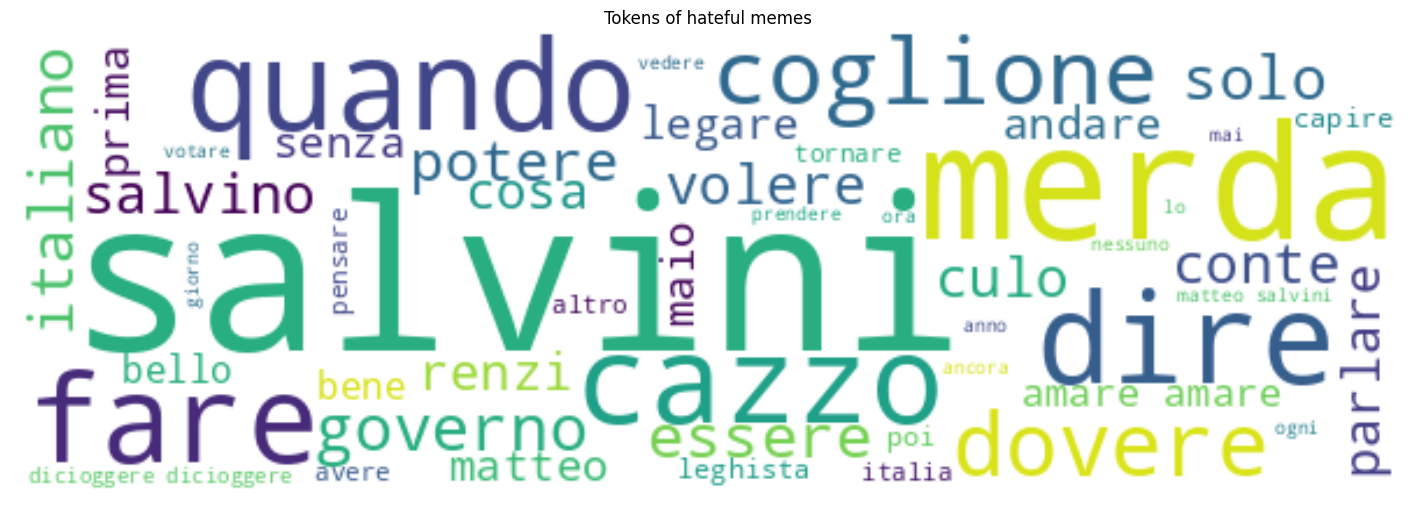

In [23]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(hateful_meme_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tokens of hateful memes")
plt.show()

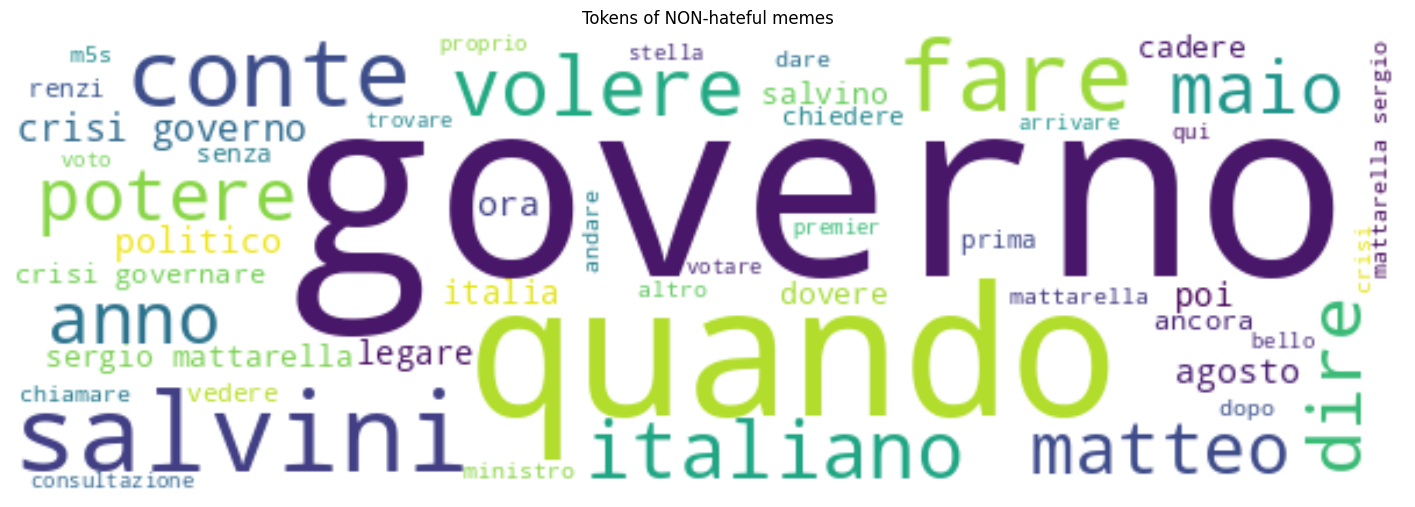

In [24]:
wordcloud = WordCloud(max_words=50, width=600, background_color='white').generate(" ".join(nonhateful_meme_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Tokens of NON-hateful memes")
plt.show()

## **Hate Score**

The hate score is given by the difference between the number of hate meme and the number of not hate meme for each of the people in 'Visual' column.

In [25]:
visuals = task_2_train['Visual']
people = []
for i in visuals:
    s = i.split(',')
    s = [j.strip() for j in s if j != ' ' and j != '']
    for e in s:
        if (e is not '0' and e.title() not in people):
            people.append(e.title())

df3 = pd.DataFrame(index=[p.title() for p in people], columns=['Hate Meme','Not Hate Meme','Hate Score'])
for p in people:
    all_by_person = task_2_train[task_2_train['Visual'].str.contains(p, case=False)]
    df3.loc[p, 'Hate Meme'] = 0-len(all_by_person[task_2_train['Hate Speech'] == 1])
    df3.loc[p, 'Not Hate Meme'] = len(all_by_person[task_2_train['Hate Speech'] == 0])
    df3.loc[p, 'Hate Score'] = len(all_by_person[task_2_train['Hate Speech'] == 0]) - len(all_by_person[task_2_train['Hate Speech'] == 1])

df3 = df3.sort_values('Hate Score')
df3.sample(n=10)

,Hate Meme,Not Hate Meme,Hate Score
Prodi,-1,0,-1
Boldrini,-2,1,-1
Giannino,-1,0,-1
Vendola,-1,0,-1
Boschi,-1,4,3
Mattarella,-33,49,16
Adinolfi,-1,0,-1
Grillo,-3,4,1
Berlusconi,-11,10,-1
Sgarbi,-1,0,-1


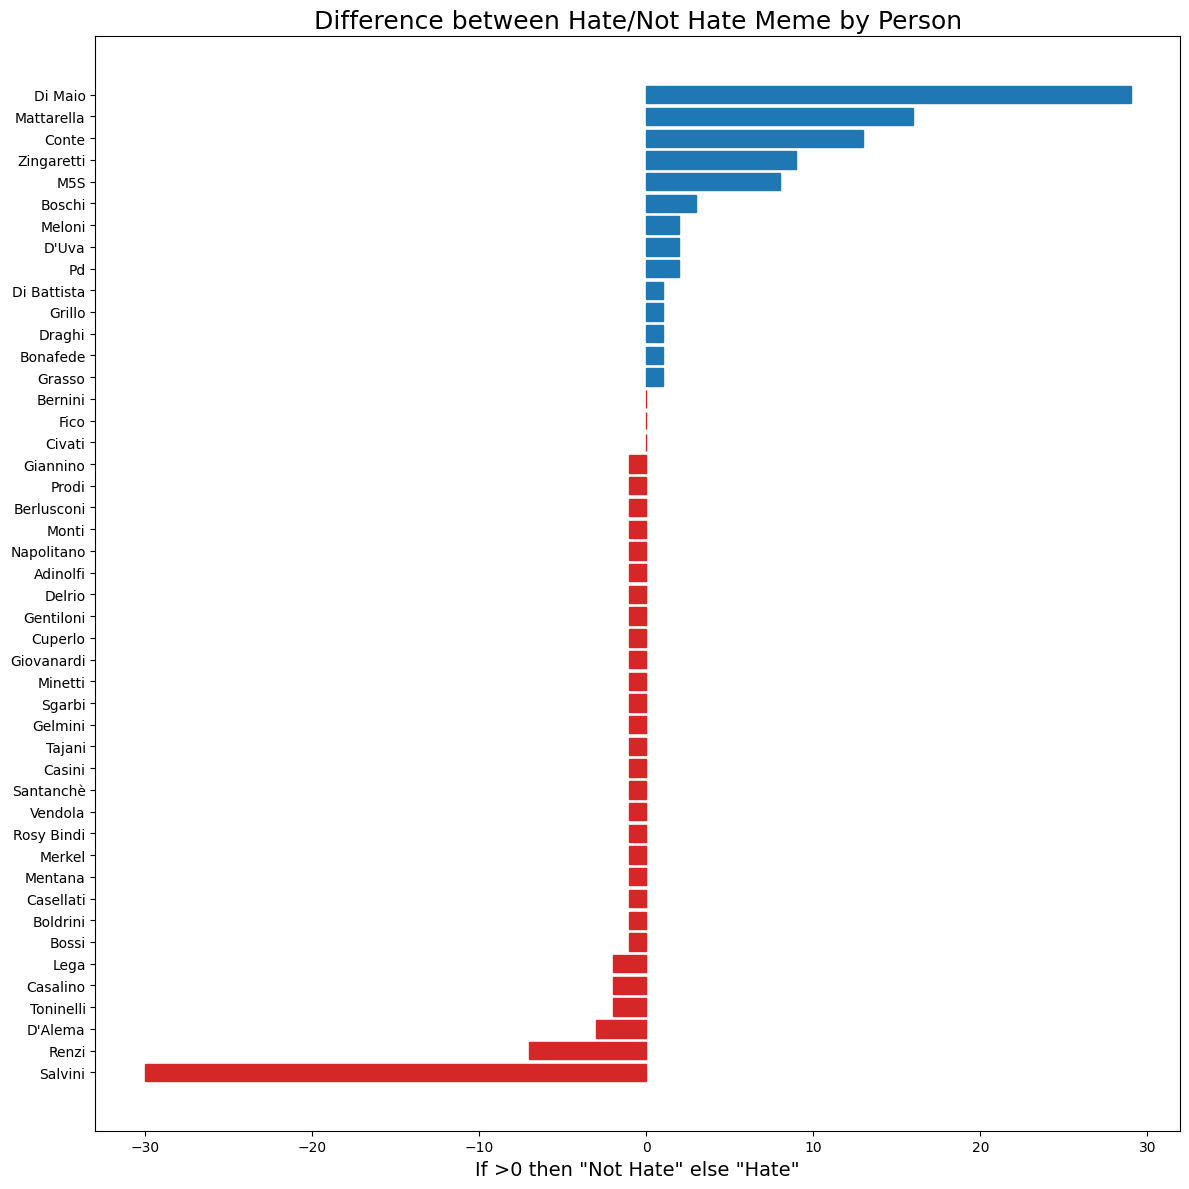

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
colors = mcolors.TABLEAU_COLORS
bars1 = ax1.barh(df3.index, width=df3['Hate Score'], color=colors)
ax1.set_xlabel('If >0 then "Not Hate" else "Hate"', fontsize = 14)
for rect in bars1:
    width = rect.get_width()
    if (width > 0):
        rect.set_color('tab:blue')
    else:
        rect.set_color('tab:red')

ax1.set_title('Difference between Hate/Not Hate Meme by Person', fontsize = 18)
plt.tight_layout()
plt.show()

In [27]:
# The hate score is given by the difference between the number of 
# hate meme and the number of not hate meme for each of the people in 'Visual' column
def get_hate_score(visual, score_df):
    score = np.NAN
    if (visual != '0'):
        visual = visual.split(',')
        visual = [j.strip().title() for j in visual if j != ' ' and j != '' and j != '0']
        score = score_df.loc[visual, 'Hate Score'].sum()
    return score

data['Hate Score'] = data['Visual'].apply(lambda x:get_hate_score(x, df3))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Hate Speech
494,1494.jpg,108,1,0,NaN,pompierino... pompierino... lo vuoi lo strisci...,pompieriare pompierino volere striscione salvi...,1
177,1177.jpg,17,0,Conte,13.0,"""te sei cacato sotto eh?"" ""eh, 'n pochetto""",cacare sotto pochetto,1
588,1588.jpg,97,0,"Meloni, Berlusconi, Salvini",-29.0,sono li da oltre 20 anni solo disastri per il ...,oltre anno solo disastre paese anno 2011 sprea...,0
569,1569.jpg,40,0,Mattarella,16.0,"serial things ok signori, chiudiamola alla caz...",serial things signore chiudiamolo cazzo cane i...,1
215,1215.jpg,54,0,Salvini,-30.0,cos'è questa storia che non mi danno la pistol...,storia dare pistola pistola,1
253,1253.jpg,19,1,Conte,13.0,dobby non ha padrony dobby è un elfo libero,dobby padrony dobby elfo libero,0
544,1544.jpg,58,1,0,NaN,quando ti chiedono perché è caduto il governo,quando chiedere cadere governo,0
220,1220.jpg,47,1,Di Maio,29.0,piattaforma russò,piattaforma russare,0
110,1110.jpg,436,0,Salvini,-30.0,prima gli italiani starter pack. padania is no...,prima italiano starter pack padania not italy ...,1
492,1492.jpg,10242,1,Salvini,-30.0,"tutti quanti dicono ""salvini razzista"" ""salvin...",dire salvini razzista salvini fascista salvini...,1


## **Number of Words**

The number of words calculated for the original 'Text' column's data.

In [28]:
data['Nr Words Text'] = data['Text'].apply(lambda x:len(str(x).split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Nr Words Text', 'Hate Speech']]
data.sample(n=10)

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Nr Words Text,Hate Speech
51,1051.jpg,17,0,"Salvini, Conte, Di Maio",12.0,salvini: ritiro la sfiducia conte: pijatela ne...,salvinie ritiro sfiducie conte pijatela culo,8,1
754,1754.jpg,9,0,0,NaN,situazione di un leghista nei commenti di un p...,situazione leghista commento post salvini ever...,16,1
188,1188.jpg,67,1,Salvini,-30.0,"voi di ""o strunz"" sarete i primi ad essere dep...",strunz primo essere deportare,10,1
687,1687.jpg,46,0,"Fico, Grillo, Di Maio",30.0,passare dal vaffanculo a vendere il culo è un ...,passare vaffanculo vendere culo attimo,10,1
218,1218.jpg,583,0,0,NaN,"governo, la mezza marcia indietro di salvini ""...",governo mezzo marcia indietro salvino dialogo ...,22,1
155,1155.jpg,10,0,Salvini,-30.0,quando sei in calo nei sondaggi e decidi di ta...,quando calo sondaggio decidi tagliare ti barba...,33,1
70,1070.jpg,65,0,0,NaN,quando ti stai appartando con una tipa e fai c...,quando appartira tipare capire pacatezza amico...,17,0
114,1114.jpg,13,1,0,NaN,"ah shit, here we go again",shit here again,6,1
456,1456.jpg,43,0,0,NaN,disastri naturali eruzioni incendi tsunami tor...,disastro naturale eruzione incendio tsunama to...,21,0
782,1782.jpg,18,0,Mattarella,16.0,5 giorni e poi li manno tutti affanculo,giorno poi manno affanculo,8,1


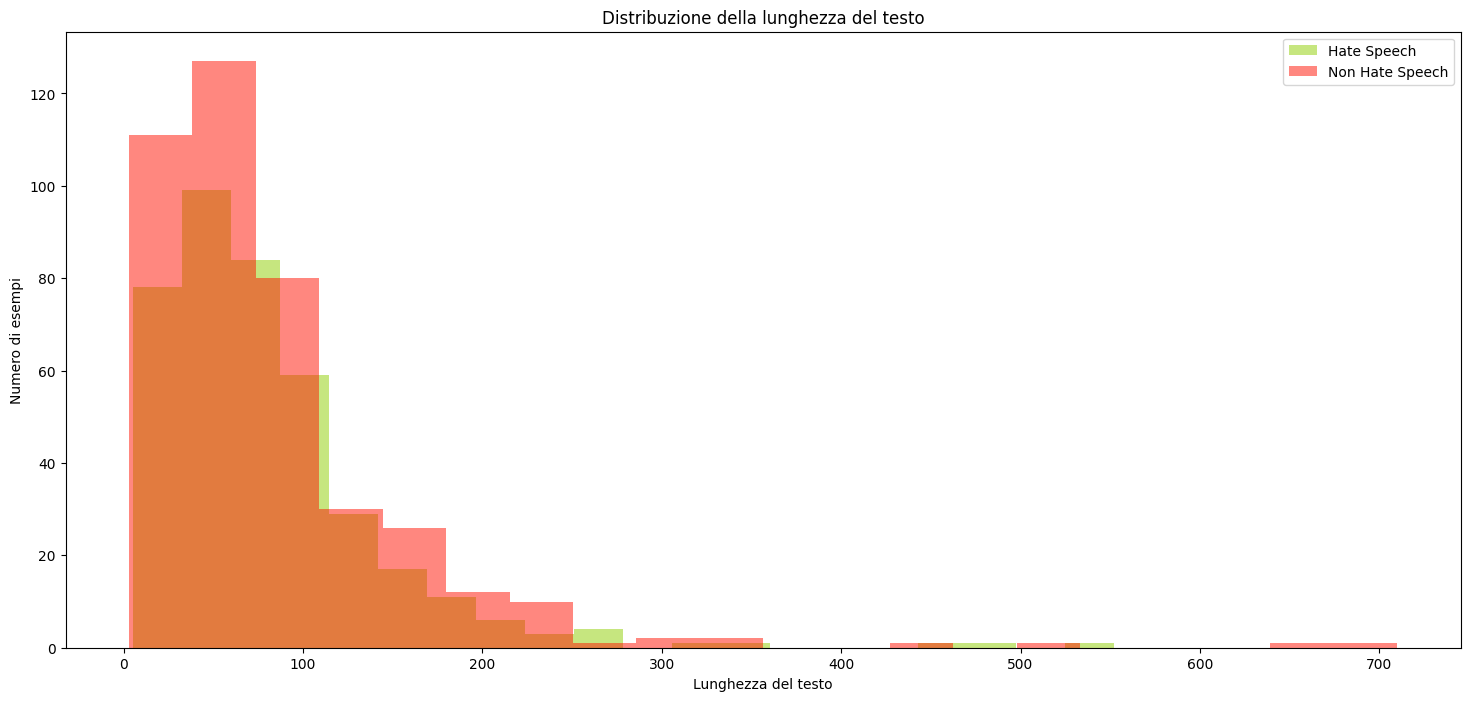

In [29]:
# Visualizzo la lunghezza del testo dei meme e delle immagini che non sono meme
# Filtra il dataset per i valori con meme = 1
meme_dataset = data[data['Hate Speech'] == 1]
non_meme_dataset = data[data['Hate Speech'] == 0]

# Calcola la lunghezza del testo per i valori con meme = 1
meme_dataset['Nr Words Text'] = meme_dataset['Text'].apply(len)
non_meme_dataset['Nr Words Text'] = non_meme_dataset['Text'].apply(len)

# Crea il plot della lunghezza del testo per meme e non meme
plt.hist(meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Hate Speech', color='#8fce00')
plt.hist(non_meme_dataset['Nr Words Text'], bins=20, alpha=0.5, label='Non Hate Speech', color='#ff1100')
plt.xlabel('Lunghezza del testo')
plt.ylabel('Numero di esempi')
plt.title('Distribuzione della lunghezza del testo')
plt.legend()
plt.show()

## **NER**

In [30]:
tokens = data['Tokens']
df4 = pd.DataFrame(columns=['File Id','Entity Name','Entity Label'])
for t in tokens:
    spacy_tokens = nlp(t)
    if spacy_tokens.ents:
        names = []
        labels = []
        for ent in spacy_tokens.ents:
            names.append(ent.text)
            labels.append(ent.label_)
        list_row = [data[data['Tokens'] == t]['File'].iat[0], ', '.join(names), ', '.join(labels)]
        df4.loc[len(df4)] = list_row

df4.sample(n=10)

,File Id,Entity Name,Entity Label
64,1128.jpg,matteo alto,PER
55,1110.jpg,"prima italiano starter pack padania not italy,...","MISC, PER"
117,1243.jpg,italia,LOC
382,1793.jpg,"salvino cantass, chello granda","PER, PER"
253,1514.jpg,italia,LOC
143,1292.jpg,temptation island,LOC
98,1210.jpg,yeah baby dimmi cosa desidero parlami amante i...,MISC
107,1226.jpg,biiiiiissssssss,LOC
380,1789.jpg,rollingstone,PER
255,1519.jpg,"italia, fabrizio andrè","LOC, PER"


## **Words Embedding**

In [31]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['Tokens'])]
d2v = Doc2Vec(vector_size=400, window=2, min_count=1)
d2v.build_vocab(documents)

In [32]:
data['Doc2Vec'] = data['Tokens'].apply(lambda x: d2v.infer_vector(x.split()))
data = data[['File', 'Engagement', 'Manipulation', 'Visual', 'Hate Score', 'Text', 'Tokens', 'Doc2Vec', 'Nr Words Text', 'Hate Speech']]
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[0.0005711149, 0.00026410312, 7.725611e-05, -0...",15,1
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[0.0007865238, 0.0011936799, -0.00031408996, -...",14,0
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.00047463932, 0.001152407, -0.0006735128, -...",17,1
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[0.0012130728, -0.0011095996, 8.39445e-05, -0....",9,1
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[-0.0007150216, -0.001036411, 0.0011507586, 0....",26,0


#**4) MODEL DEFINITION**

---


## **Create final dataset with image embeddings**

In [33]:
task_2_embeddings = pd.read_csv(BASE_PATHS[1] + FILENAMES[4], header=None)
task_2_embeddings.head()

,0,1
0,1000.jpg,0.03371752053499222 0.7138307690620422 0.16221...
1,1001.jpg,0.017445266246795654 0.016754239797592163 0.06...
2,1002.jpg,0.2331690937280655 2.1796271800994873 0.0 0.00...
3,1003.jpg,0.09365507960319519 1.8714182376861572 0.52478...
4,1004.jpg,0.1272037923336029 1.260957956314087 0.1069836...


In [34]:
data['Image_embeddings'] = task_2_embeddings.loc[:][1]

def convert_to_float_list(string):
  values = string.split()
  for i in range(0, len(values)):
    values[i] = float(values[i])

    return values

data['Image_embeddings_float'] = np.array(data['Image_embeddings'].apply(convert_to_float_list))
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,Image_embeddings,Image_embeddings_float
0,1000.jpg,381,0,0,NaN,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[0.0005711149, 0.00026410312, 7.725611e-05, -0...",15,1,0.03371752053499222 0.7138307690620422 0.16221...,"[0.03371752053499222, 0.7138307690620422, 0.16..."
1,1001.jpg,142,1,0,NaN,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[0.0007865238, 0.0011936799, -0.00031408996, -...",14,0,0.017445266246795654 0.016754239797592163 0.06...,"[0.017445266246795654, 0.016754239797592163, 0..."
2,1002.jpg,3598,1,"Di Maio, Zingaretti, Berlusconi, Salvini",7.0,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.00047463932, 0.001152407, -0.0006735128, -...",17,1,0.2331690937280655 2.1796271800994873 0.0 0.00...,"[0.2331690937280655, 2.1796271800994873, 0.0, ..."
3,1003.jpg,165,1,"Salvini, Renzi",-37.0,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[0.0012130728, -0.0011095996, 8.39445e-05, -0....",9,1,0.09365507960319519 1.8714182376861572 0.52478...,"[0.09365507960319519, 1.8714182376861572, 0.52..."
4,1004.jpg,44,0,0,NaN,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[-0.0007150216, -0.001036411, 0.0011507586, 0....",26,0,0.1272037923336029 1.260957956314087 0.1069836...,"[0.1272037923336029, 1.260957956314087, 0.1069..."


Scaling delle colonne numeriche

In [35]:
scaler = MinMaxScaler()

data['Engagement'] = scaler.fit_transform(data['Engagement'].values.reshape(-1, 1))
data['Nr Words Text'] = scaler.fit_transform(data['Nr Words Text'].values.reshape(-1, 1))

# replace Nan values with 0
data['Hate Score'] = data['Hate Score'].fillna(0)
data['Hate Score'] = scaler.fit_transform(data['Hate Score'].values.reshape(-1, 1))
data.head()

,File,Engagement,Manipulation,Visual,Hate Score,Text,Tokens,Doc2Vec,Nr Words Text,Hate Speech,Image_embeddings,Image_embeddings_float
0,1000.jpg,0.009771,0,0,0.385417,quando ti chiedono se sia peggiore fratelli d'...,quando chiedere peggiore fratello italia legar...,"[0.0005711149, 0.00026410312, 7.725611e-05, -0...",0.115702,1,0.03371752053499222 0.7138307690620422 0.16221...,"[0.03371752053499222, 0.7138307690620422, 0.16..."
1,1001.jpg,0.003642,1,0,0.385417,conte entra in un negozio di telefonia e passa...,conte entrare negozio telefonia passare manten...,"[0.0007865238, 0.0011936799, -0.00031408996, -...",0.107438,0,0.017445266246795654 0.016754239797592163 0.06...,"[0.017445266246795654, 0.016754239797592163, 0..."
2,1002.jpg,0.092271,1,"Di Maio, Zingaretti, Berlusconi, Salvini",0.458333,i politicanti italici non vedono l'ora di anda...,politicante italico vedere ora andare urna acc...,"[-0.00047463932, 0.001152407, -0.0006735128, -...",0.132231,1,0.2331690937280655 2.1796271800994873 0.0 0.00...,"[0.2331690937280655, 2.1796271800994873, 0.0, ..."
3,1003.jpg,0.004231,1,"Salvini, Renzi",0.000000,sono scemo. io di più. scemo & più scemo,scemo scemo scemapere,"[0.0012130728, -0.0011095996, 8.39445e-05, -0....",0.066116,1,0.09365507960319519 1.8714182376861572 0.52478...,"[0.09365507960319519, 1.8714182376861572, 0.52..."
4,1004.jpg,0.001128,0,0,0.385417,"beppe grillo (2017) genova, 21 luglio 1948 pol...",beppe grillo 2017 genova luglio 1948 politico ...,"[-0.0007150216, -0.001036411, 0.0011507586, 0....",0.206612,0,0.1272037923336029 1.260957956314087 0.1069836...,"[0.1272037923336029, 1.260957956314087, 0.1069..."


In [36]:
X1 = data[['Engagement', 'Manipulation', 'Hate Score', 'Nr Words Text']].values
X2 = data[['Image_embeddings_float']].values
X3 = data[['Doc2Vec']].values
y = data['Hate Speech'].values

In [37]:
X1_shape = X1.shape
X1 = X1.reshape(X1.shape[0],X1.shape[1],1)

In [38]:
import keras


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPool2D
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [39]:
# defining the hyperparameter
epochs = 45
model = Sequential()

# FIRST LAYER
model.add(Conv1D(32,2,activation = 'relu',input_shape = X1.shape))
model.add(BatchNormalization())
'''Batch normalization is a technique for training very deep neural networks 
   that standardizes the inputs to a layer for each mini-batch. This 
   has the effect of stabilizing the learning process and dramatically
   reducing the number of training epochs required to train deep networks'''
model.add(Dropout(0.2)) # prevents over-fitting (randomly remove some neurons)

# SECOND LAYER
model.add(Conv1D(64,2,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Flattening the layer ( multidimentional data into vector)
model.add(Flatten())
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.5))

# FINAL LAYER
model.add(Dense(1,activation='sigmoid'))

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 800, 3, 32)        96        
                                                                 
 batch_normalization (BatchN  (None, 800, 3, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 800, 3, 32)        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 800, 2, 64)        4160      
                                                                 
 batch_normalization_1 (Batc  (None, 800, 2, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 800, 2, 64)       

In [41]:
epochs=20
history = model.fit(X1, y, batch_size=32,
                    epochs=epochs)

Epoch 1/20


ValueError: ignored